In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
import jax.random as r
import distrax as dx
import matplotlib.pyplot as plt

2024-11-06 15:48:33.304808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730908113.320072 2254474 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730908113.324476 2254474 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import optax as ox

In [4]:
import flax.nnx as nnx

In [5]:
from typing import TypeVar

In [6]:
import sys
import os

# Navigate the current notebook directory to src directory
current_dir = os.getcwd()
jax_eco_dir = os.path.dirname(os.path.dirname(current_dir))
src_dir = os.path.join(jax_eco_dir, 'src')
sys.path.append(jax_eco_dir)

# Now you can import the module
import src.np_from_scratch as npfs

: 

# Device stuff


In [ ]:
jax.devices()

# Main content

In [51]:
key0 = r.PRNGKey(0)

In [107]:
TRAINING_ITERATIONS = int(2e5)
MAX_CONTEXT_POINTS = 30
PLOT_AFTER = int(2e4)

In [94]:
curve_reader = npfs.GPCurvesReader(
    batch_size=8, max_num_context=MAX_CONTEXT_POINTS)

In [95]:
cnp_spec = npfs.CNPSpec(
    x_dim=1, y_dim=1, r_dim=64,
    encoder_hidden_output_sizes=[64, 64],
    decoder_hidden_output_sizes=[32, 32],
)

model = npfs.CNP(cnp_spec=cnp_spec, rngs=nnx.Rngs(0))

In [106]:
learning_rate = 2e-3
momentum = 0.9

optimizer = nnx.Optimizer(model, ox.adamw(learning_rate, momentum))
metrics = nnx.metrics.Average('log_prob')

def loss_fn(model: npfs.CNP, batch: npfs.CNPRegressionInstance):
    return -model.log_prob(batch).mean()

@nnx.jit
def train_step(
    model: npfs.CNP, 
    optimizer: nnx.Optimizer,
    metrics: nnx.metrics.Metric, 
    batch: npfs.CNPRegressionInstance,
):
    grad_fn = nnx.value_and_grad(loss_fn)
    log_prob, grad = grad_fn(model, batch)
    # in place updates
    metrics.update(log_prob=log_prob)
    optimizer.update(grad) 

@nnx.jit
def eval_step(model: npfs.CNP, metrics: nnx.metrics.Metric, batch: npfs.CNPRegressionInstance):
    log_prob = model.log_prob(batch)
    metrics.update(log_prob=log_prob)

### Plot before training to debug forward passes and plotting code

In [97]:
# test plot function out for initialised model
batch = curve_reader.generate_regression_instance(key=key0, eval_mode=True)
print(type(batch))
preds = model.predictive(batch.query)


<class 'src.np_from_scratch.CNPRegressionInstance'>


Rather unhelpfully, the mean and standard deviation come to zero!
This was because NaNs came from the GP ys.  
I did a temporary fix by reducing the number of design points.  
Nice to implement a better generating mechanism later.

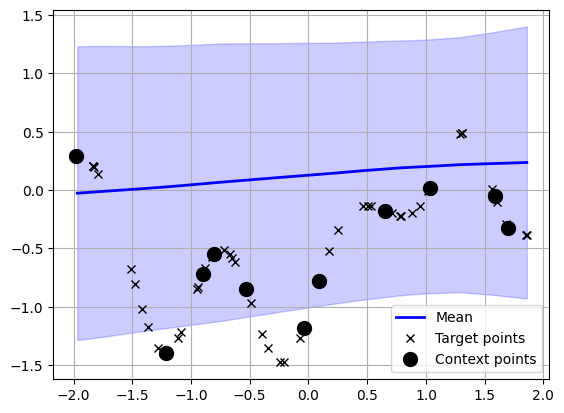

In [98]:
npfs.plot_functions(batch.query, batch.target_y, preds.mean(), preds.stddev())

Note: this is reassuring: the initial model weights seem to result in a zero mean function with reasonable variance.  
Not really clear why this happens mind!  
Guess there is some sensible default initialisation in the linear layers.

## Training run

In [99]:
metrics_history = {
    'log_prob': [],
}

Might also want to run an 'oracle' log_prob, but this seems good for now

In [100]:
print(TRAINING_ITERATIONS)

200000


In [108]:
TRAINING_ITERATIONS = 200
eval_every = 1

# possible to do: have a number of eval batches
# think good as is for now

In [109]:
metrics_history = {
    'log_prob': [],
}

In [110]:
for step in range(TRAINING_ITERATIONS):
    key = r.fold_in(key0, step)
    batch = curve_reader.generate_regression_instance(key=key)
    train_step(model, optimizer, metrics, batch)

    print(f"Step {step}, log_prob: {metrics.compute()}")
    metrics_history['log_prob'].append(metrics.compute())

Step 0, log_prob: 1.3615316152572632
Step 1, log_prob: 1.312382698059082
Step 2, log_prob: 1.3448480367660522
Step 3, log_prob: 1.3681937456130981
Step 4, log_prob: 1.3405567407608032
Step 5, log_prob: 1.3151311874389648
Step 6, log_prob: 1.303070068359375
Step 7, log_prob: 1.3120635747909546
Step 8, log_prob: 1.345217227935791
Step 9, log_prob: 1.338809609413147
Step 10, log_prob: 1.3271000385284424
Step 11, log_prob: 1.3207930326461792
Step 12, log_prob: 1.3220164775848389
Step 13, log_prob: 1.3253966569900513
Step 14, log_prob: 1.3213810920715332
Step 15, log_prob: 1.327009677886963
Step 16, log_prob: 1.3199719190597534
Step 17, log_prob: 1.3236804008483887
Step 18, log_prob: 1.3229715824127197
Step 19, log_prob: 1.3292747735977173
Step 20, log_prob: 1.329514741897583
Step 21, log_prob: 1.3312716484069824
Step 22, log_prob: 1.3298003673553467
Step 23, log_prob: 1.3291500806808472
Step 24, log_prob: 1.3225433826446533
Step 25, log_prob: 1.319886565208435
Step 26, log_prob: 1.33021259

Note, no need to worry about train test separate evaluation because they each batch is independent

Text(0, 0.5, 'NLL')

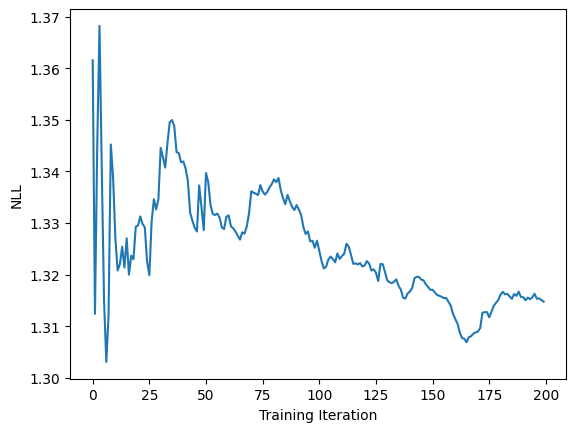

In [111]:
# plot the metric progress
plt.plot(metrics_history['log_prob'])
plt.xlabel('Training Iteration')
plt.ylabel('NLL')

Interestingly, there seems to be a local optimum found early on.  
Not clear why or how.  
Let's have a look at the predictions anyhow...

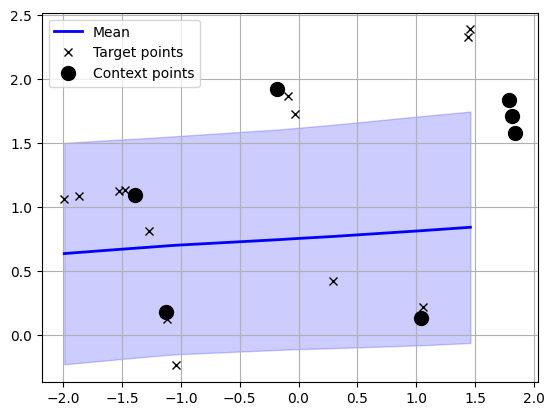

In [112]:
# see how final model performs on same previous batch

preds = model.predictive(batch.query)
npfs.plot_functions(batch.query, batch.target_y, preds.mean(), preds.stddev())

Conclusion: actually that looks pretty good!

The number of context points is so low that there is relatively little the model can say confidently.  

What else would be interesting to try?
- speed up with gpu
- further increase number of context points
- implement some iterative resampling

Second conclusion: actually not so good!  
The increase in learning rate did not help.  
Think one does just need to train for a very long time, even in this simple setting - let's see what the GPU can do to help...